## Instacart Market Basket Analysis - Final Analysis

Instacart is a technology company providing a same day delivery grocery service to users across the U.S and Canada. Users place their grocery orders through the Instacart app and a personal Instacart shopper delivers the order to their home.

Instacart made public an anonymized data of 3 million Instacart shoppers presenting researchers with the challenge of predicting which previously purchased products will be in the user’s next order. 

This report includes the following processes:

- the selection of Instacart users <br>
- data extraction <br>
- features model creation
- splitting of data into train and test data <br>
- 3 Machine Learning models <br> 
- testing and prediction <br>

Files downloaded from Kaggle website as part of the Kaggle Instacart Market Basket Analysis competition:
- orders.csv <br>
- order_products__prior.csv <br>
- order_products__train.csv <br>
- products.csv <br>
- aisles.csv <br>
- departments.csv <br>

Data source: https://www.kaggle.com/c/instacart-market-basket-analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reading csv files into Pandas DataFrames

filename_orders_file = 'files/orders.csv'
filename_products_prior = 'files/order_products__prior.csv'
filename_products_train= 'files/order_products__train.csv'
filename_products = 'files/products.csv'
filename_aisles = 'files/aisles.csv'
filename_departments = 'files/departments.csv'

orders = pd.read_csv(filename_orders_file , dtype={
            'order_id': np.int32,
            'user_id': np.int32,
            'eval_set': 'category',
            'order_number': np.int16,
            'order_dow': np.int8,
            'order_hour_of_day': np.int8,
            'days_since_prior_order': np.float32})
order_products_prior = pd.read_csv(filename_products_prior, dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
order_products_train= pd.read_csv(filename_products_train, dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
products = pd.read_csv(filename_products, dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'aisle_id': np.uint8,
            'department_id': np.uint8})
aisles = pd.read_csv(filename_aisles)
departments = pd.read_csv(filename_departments)

# Sample selection

In [3]:
# Orders with train eval_set are selected
orders_train = orders.loc[orders['eval_set'] == 'train']

In [4]:
# A random selection of users is made from orders
unique_orders = pd.DataFrame(orders_train['user_id'].unique(), columns=['user_id'])
selected_users = unique_orders.sample(frac = 0.385)
print("Data sample has",len(selected_users), "unique users")

Data sample has 50515 unique users


In [5]:
#train orders 
selected_users = orders['user_id'].isin(selected_users['user_id'])
orders_tr = orders[selected_users]
orders_tr.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0


In [6]:
# order_products_prior is merged with selected train orders
priors = pd.merge(orders_tr,order_products_prior,  on='order_id')
priors.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0


# Product features

In [7]:
# product information is added to users and orders selected. d_X dataframe is created and will be added features.
df = pd.merge(priors.drop('eval_set',axis=1), products.drop('product_name', axis=1), on='product_id')
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,2539329,1,1,2,8,NaN,196,1,0,77,7
1,2398795,1,2,3,7,15.0,196,1,1,77,7


In [8]:
# accounting for days_since_prior_order column NaN
df['days_since_prior_order'].fillna(0, inplace = True)

In [9]:
#products reordered ratio
reorder_ratio = pd.DataFrame()
reorder_ratio['number_orders'] = df.groupby('product_id').size().astype(np.int16)
reorder_ratio['number_reorders'] = df.groupby('product_id')['reordered'].apply(lambda x: x[x == 1].count()).astype(np.int16)
reorder_ratio['reordered_ratio'] = reorder_ratio['number_reorders']/reorder_ratio['number_orders']
reorder_ratio.head(2)

,number_orders,number_reorders,reordered_ratio
product_id,,,
1,487,320,0.657084
2,22,6,0.272727


In [10]:
avg_order_time = pd.DataFrame()
avg_order_time['avg_days_since_prior_order'] = df.groupby('product_id')['days_since_prior_order'].mean()
avg_order_time.head(2)

,avg_days_since_prior_order
product_id,
1,9.437371
2,6.681818


In [11]:
products_stats = pd.merge(reorder_ratio, avg_order_time, on='product_id')
df = pd.merge(df, products_stats, on='product_id')

# User behavior features

In [12]:
user_product_reorder =  pd.DataFrame()
user_product_reorder['user_reorder_ratio'] = df.groupby(['product_id','user_id'])['reordered'].mean()
user_product_reorder['user_reorder_sum'] = df.groupby(['product_id','user_id'])['reordered'].sum().astype(np.int16)
user_product_reorder = user_product_reorder.reset_index()
#user_product_reorder.head(2)

In [13]:
df = pd.merge(df, user_product_reorder, on=['user_id','product_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,number_orders,number_reorders,reordered_ratio,avg_days_since_prior_order,user_reorder_ratio,user_reorder_sum
0,2539329,1,1,2,8,0.0,196,1,0,77,7,8716,6753,0.774782,11.404887,0.9,9
1,2398795,1,2,3,7,15.0,196,1,1,77,7,8716,6753,0.774782,11.404887,0.9,9


In [14]:
user_aisle_reorder =  pd.DataFrame()
user_aisle_reorder['user_aisle_reorder_ratio'] = df.groupby(['aisle_id','user_id'])['reordered'].mean()
user_aisle_reorder['user_aisle_reorder_sum'] = df.groupby(['aisle_id','user_id'])['reordered'].sum().astype(np.int16)
user_aisle_reorder = user_aisle_reorder.reset_index()

In [15]:
df = pd.merge(df, user_aisle_reorder, on=['aisle_id','user_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,number_orders,number_reorders,reordered_ratio,avg_days_since_prior_order,user_reorder_ratio,user_reorder_sum,user_aisle_reorder_ratio,user_aisle_reorder_sum
0,2539329,1,1,2,8,0.0,196,1,0,77,7,8716,6753,0.774782,11.404887,0.9,9,0.846154,11
1,2398795,1,2,3,7,15.0,196,1,1,77,7,8716,6753,0.774782,11.404887,0.9,9,0.846154,11


In [16]:
user_department_reorder =  pd.DataFrame()
user_department_reorder['user_department_reorder_ratio'] = df.groupby(['department_id','user_id'])['reordered'].mean()
user_department_reorder['user_department_reorder_sum'] = df.groupby(['department_id','user_id'])['reordered'].sum().astype(np.int16)
user_department_reorder = user_department_reorder.reset_index()

In [17]:
df = pd.merge(df, user_department_reorder, on=['department_id','user_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,number_orders,number_reorders,reordered_ratio,avg_days_since_prior_order,user_reorder_ratio,user_reorder_sum,user_aisle_reorder_ratio,user_aisle_reorder_sum,user_department_reorder_ratio,user_department_reorder_sum
0,2539329,1,1,2,8,0.0,196,1,0,77,...,8716,6753,0.774782,11.404887,0.9,9,0.846154,11,0.846154,11
1,2398795,1,2,3,7,15.0,196,1,1,77,...,8716,6753,0.774782,11.404887,0.9,9,0.846154,11,0.846154,11


In [18]:
avg_time_orders = pd.DataFrame()
avg_time_orders['user_average_days_between_orders'] = orders_tr.groupby('user_id')['days_since_prior_order'].mean()
avg_time_orders['user_number_orders'] = orders_tr.groupby('user_id').size().astype(np.int16)
avg_time_orders.head(2)

,user_average_days_between_orders,user_number_orders
user_id,,
1,19.0,11
5,11.5,5


In [19]:
user_products_orders =  pd.DataFrame()
user_products_orders['user_product_orders'] = df.groupby(['product_id','user_id'])['user_id'].size().astype(np.int16)
user_products_orders['user_products_order_rate'] = user_products_orders['user_product_orders'] / avg_time_orders['user_number_orders']
user_products_orders = user_products_orders.reset_index()

In [20]:
df = pd.merge(df, user_products_orders, on=['user_id','product_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,reordered_ratio,avg_days_since_prior_order,user_reorder_ratio,user_reorder_sum,user_aisle_reorder_ratio,user_aisle_reorder_sum,user_department_reorder_ratio,user_department_reorder_sum,user_product_orders,user_products_order_rate
0,2539329,1,1,2,8,0.0,196,1,0,77,...,0.774782,11.404887,0.9,9,0.846154,11,0.846154,11,10,0.909091
1,2398795,1,2,3,7,15.0,196,1,1,77,...,0.774782,11.404887,0.9,9,0.846154,11,0.846154,11,10,0.909091


In [21]:
user_products = pd.DataFrame()
user_products['user_total_items'] = df.groupby('user_id').size().astype(np.int16)
user_products['all_products'] =  df.groupby('user_id')['product_id'].apply(set)
user_products['user_total_distinct_items'] = (user_products.all_products.map(len)).astype(np.int16)
user_products.head(2)

,user_total_items,all_products,user_total_distinct_items
user_id,,,
1,59,"{17122, 196, 46149, 14084, 26405, 26088, 39657...",18
5,37,"{28289, 11777, 40706, 48775, 20754, 6808, 1398...",23


In [22]:
users_shopping_behavior = pd.merge(user_products.drop('all_products', axis=1), avg_time_orders, on='user_id')
users_shopping_behavior['user_average_basket'] = (user_products['user_total_items'] / avg_time_orders['user_number_orders'])
users_shopping_behavior.head(2)

,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket
user_id,,,,,
1,59,18,19.0,11,5.363636
5,37,23,11.5,5,7.400000


In [23]:
df = pd.merge(df, users_shopping_behavior, on = 'user_id')
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_aisle_reorder_sum,user_department_reorder_ratio,user_department_reorder_sum,user_product_orders,user_products_order_rate,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket
0,2539329,1,1,2,8,0.0,196,1,0,77,...,11,0.846154,11,10,0.909091,59,18,19.0,11,5.363636
1,2398795,1,2,3,7,15.0,196,1,1,77,...,11,0.846154,11,10,0.909091,59,18,19.0,11,5.363636


In [24]:
cart_order_user =  pd.DataFrame()
cart_order_user['user_add_to_cart_order'] = df.groupby(['product_id','user_id'])['add_to_cart_order'].mean()
cart_order_user = cart_order_user.reset_index()
cart_order_user.head(2)

,product_id,user_id,user_add_to_cart_order
0,1,138,3.0
1,1,1052,1.5


In [25]:
df = pd.merge(df, cart_order_user,on=['user_id','product_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_department_reorder_ratio,user_department_reorder_sum,user_product_orders,user_products_order_rate,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order
0,2539329,1,1,2,8,0.0,196,1,0,77,...,0.846154,11,10,0.909091,59,18,19.0,11,5.363636,1.4
1,2398795,1,2,3,7,15.0,196,1,1,77,...,0.846154,11,10,0.909091,59,18,19.0,11,5.363636,1.4


In [26]:
day_of_week_user =  pd.DataFrame()
day_of_week_user['user_day_of_week'] = df.groupby(['product_id','user_id'])['order_dow'].mean()
day_of_week_user = day_of_week_user.reset_index()
day_of_week_user.head(2)

,product_id,user_id,user_day_of_week
0,1,138,6.0
1,1,1052,1.0


In [27]:
df = pd.merge(df, day_of_week_user, on=['user_id','product_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_department_reorder_sum,user_product_orders,user_products_order_rate,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week
0,2539329,1,1,2,8,0.0,196,1,0,77,...,11,10,0.909091,59,18,19.0,11,5.363636,1.4,2.5
1,2398795,1,2,3,7,15.0,196,1,1,77,...,11,10,0.909091,59,18,19.0,11,5.363636,1.4,2.5


In [28]:
avg_time_day_user = pd.DataFrame()
avg_time_day_user['user_order_hour_of_day'] = df.groupby(['product_id','user_id'])['order_hour_of_day'].mean()
avg_time_day_user = avg_time_day_user.reset_index()
avg_time_day_user.head(2)

,product_id,user_id,user_order_hour_of_day
0,1,138,14.0
1,1,1052,16.0


In [29]:
df = pd.merge(df, avg_time_day_user, on=['user_id','product_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_product_orders,user_products_order_rate,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week,user_order_hour_of_day
0,2539329,1,1,2,8,0.0,196,1,0,77,...,10,0.909091,59,18,19.0,11,5.363636,1.4,2.5,10.3
1,2398795,1,2,3,7,15.0,196,1,1,77,...,10,0.909091,59,18,19.0,11,5.363636,1.4,2.5,10.3


# Time related features

In [30]:
cart_order = pd.DataFrame()
cart_order['number_reorders_by_cart'] = df.groupby('add_to_cart_order')['reordered'].size()
cart_order['avg_reorders'] = cart_order['number_reorders_by_cart']/(np.sum(cart_order['number_reorders_by_cart']))
cart_order.head(2)

,number_reorders_by_cart,avg_reorders
add_to_cart_order,,
1,785724,0.098939
2,747374,0.094110


In [31]:
df = pd.merge(df, cart_order, on='add_to_cart_order')
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week,user_order_hour_of_day,number_reorders_by_cart,avg_reorders
0,2539329,1,1,2,8,0.0,196,1,0,77,...,59,18,19.0,11,5.363636,1.4,2.5,10.3,785724,0.098939
1,2398795,1,2,3,7,15.0,196,1,1,77,...,59,18,19.0,11,5.363636,1.4,2.5,10.3,785724,0.098939


In [32]:
avg_day_of_week = pd.DataFrame()
avg_day_of_week['product_avg_day_of_week'] = df.groupby('product_id')['order_dow'].mean()
avg_day_of_week.head(2)

,product_avg_day_of_week
product_id,
1,2.761807
2,3.409091


In [33]:
df = pd.merge(df, avg_day_of_week, on='product_id', how='left')
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week,user_order_hour_of_day,number_reorders_by_cart,avg_reorders,product_avg_day_of_week
0,2539329,1,1,2,8,0.0,196,1,0,77,...,18,19.0,11,5.363636,1.4,2.5,10.3,785724,0.098939,2.888596
1,2398795,1,2,3,7,15.0,196,1,1,77,...,18,19.0,11,5.363636,1.4,2.5,10.3,785724,0.098939,2.888596


In [34]:
avg_time_day = pd.DataFrame()
avg_time_day['avg_order_hour_of_day'] = df.groupby('product_id')['order_hour_of_day'].mean()
avg_time_day.head(3)

,avg_order_hour_of_day
product_id,
1,12.930185
2,11.727273
3,10.701149


In [35]:
df = pd.merge(df, avg_time_day, on='product_id', how='left')

# Features dataframe

In [36]:
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week,user_order_hour_of_day,number_reorders_by_cart,avg_reorders,product_avg_day_of_week,avg_order_hour_of_day
0,2539329,1,1,2,8,0.0,196,1,0,77,...,19.0,11,5.363636,1.4,2.5,10.3,785724,0.098939,2.888596,12.479119
1,2398795,1,2,3,7,15.0,196,1,1,77,...,19.0,11,5.363636,1.4,2.5,10.3,785724,0.098939,2.888596,12.479119


In [37]:
#feature columns. Reordered column will be designated as the target variable.
print(df.columns.values)

['order_id' 'user_id' 'order_number' 'order_dow' 'order_hour_of_day'
 'days_since_prior_order' 'product_id' 'add_to_cart_order' 'reordered'
 'aisle_id' 'department_id' 'number_orders' 'number_reorders'
 'reordered_ratio' 'avg_days_since_prior_order' 'user_reorder_ratio'
 'user_reorder_sum' 'user_aisle_reorder_ratio' 'user_aisle_reorder_sum'
 'user_department_reorder_ratio' 'user_department_reorder_sum'
 'user_product_orders' 'user_products_order_rate' 'user_total_items'
 'user_total_distinct_items' 'user_average_days_between_orders'
 'user_number_orders' 'user_average_basket' 'user_add_to_cart_order'
 'user_day_of_week' 'user_order_hour_of_day' 'number_reorders_by_cart'
 'avg_reorders' 'product_avg_day_of_week' 'avg_order_hour_of_day']


# Data splitting and modeling

In [38]:
order_unique = pd.DataFrame(df['order_id'].unique(), columns=['order_id'])
print('The sample has',len(order_unique),'orders')

The sample has 785724 orders


In [39]:
#A split of 70% train and 30% test of unique users
df_Xtr = order_unique.sample(frac = 0.7)
df_Xte = order_unique.loc[~order_unique.order_id.isin(df_Xtr.order_id)]

In [40]:
df_Xtrain = df.order_id.isin(df_Xtr.order_id)
df_Xtest = df.order_id.isin(df_Xte.order_id)

In [41]:
#adding data information to user
df_Xtrain1 = df[df_Xtrain]
df_Xtest1 = df[df_Xtest]

In [42]:
#target variable is the reordered column
ytrain, ytest = df_Xtrain1['reordered'].values, df_Xtest1['reordered'].values
Xtrain, Xtest = df_Xtrain1.drop(['reordered','user_id','order_id','order_number'],axis=1), \
                df_Xtest1.drop(['reordered','user_id','order_id','order_number'],axis=1), \

In [43]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [44]:
#scaling train data
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns).values

In [45]:
#scaling test data
Xtest = pd.DataFrame(scaler.fit_transform(Xtest), columns=Xtest.columns).values

# Logistic Regression Model

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [185]:
clf_lr = LogisticRegression(solver='lbfgs', C=.1)

In [186]:
clf_lr.fit(Xtrain, ytrain)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [187]:
y_pred_lr = clf_lr.predict(Xtest)

Confusion Matrix:
[[ 725253  256620]
 [ 109429 1293031]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80    981873
           1       0.84      0.91      0.87   1402460

    accuracy                           0.84   2384333
   macro avg       0.84      0.83      0.83   2384333
weighted avg       0.84      0.84      0.84   2384333

Accuracy: 0.8428310978374246


Precision:              0.84
Recall:                 0.91


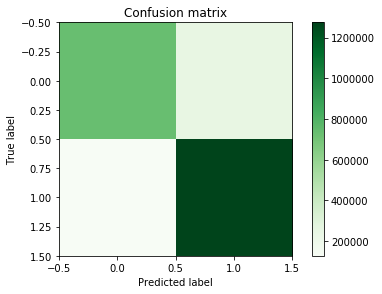

In [188]:
from sklearn.metrics import classification_report
print("Confusion Matrix:")
print(result)
result1 = classification_report(ytest, y_pred_lr)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(ytest,y_pred_lr)
print("Accuracy:",result2)

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ytest
y_pred_lr = clf_lr.predict(Xtest)


conf = confusion_matrix(y_true, y_pred_lr)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_pred_lr, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

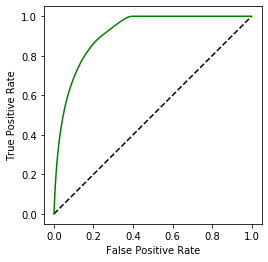

In [50]:
from sklearn.metrics import roc_curve, auc

#clf = LogisticRegression(solver='lbfgs',C=1)
#Fit the model on the trainng data.
#clf.fit(Xtrain, ytrain)
y_score = clf.predict_proba(Xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')

Features that predict class 1
Feature: 2, Score: 0.49529
Feature: 5, Score: 0.00170
Feature: 11, Score: 2.62974
Feature: 12, Score: 0.06253
Feature: 16, Score: 0.01578
Feature: 17, Score: 0.06253
Feature: 19, Score: 0.02572
Feature: 23, Score: 0.00857
Feature: 24, Score: 0.32791
Feature: 25, Score: 0.00922
Feature: 26, Score: 0.02154
Feature: 27, Score: 0.05521
Feature: 28, Score: 0.05521
Feature: 29, Score: 0.00153
Feature: 30, Score: 0.00187

Features that predict class 0
Feature: 0, Score: -0.00594
Feature: 1, Score: -0.02424
Feature: 3, Score: -0.00256
Feature: 4, Score: -0.29841
Feature: 6, Score: -0.00192
Feature: 7, Score: -0.00337
Feature: 8, Score: -0.00357
Feature: 9, Score: -0.00327
Feature: 10, Score: -0.02131
Feature: 13, Score: -0.02466
Feature: 14, Score: -0.00293
Feature: 15, Score: -0.06327
Feature: 18, Score: -0.04585
Feature: 20, Score: -0.04358
Feature: 21, Score: -0.24919
Feature: 22, Score: -0.00557


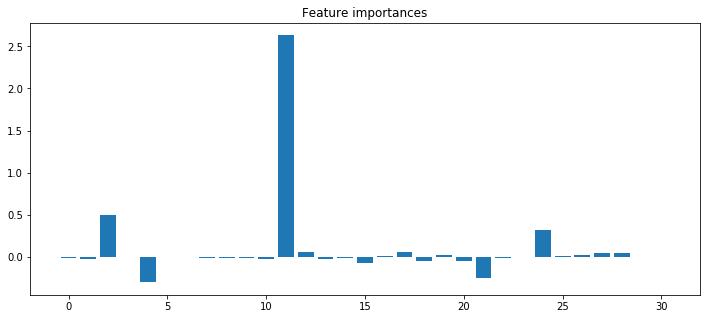

In [162]:
importance = clf_lr.coef_[0]
# summarize feature importance
print('Features that predict class 1')
for i,v in enumerate(importance):
    if v > 0:
        print('Feature: %0d, Score: %.5f' % (i,v))
print()
print('Features that predict class 0')
for i,v in enumerate(importance):
    if v < 0:
        print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
plt.figure(figsize=(12,5))
plt.title("Feature importances")
plt.bar([x for x in range(len(importance))], importance)
#plt.xticks(range(Xtrain.shape[1]), indices)
#plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [173]:
train_acc_lr=clf_lr.score(Xtrain, ytrain)
test_acc_lr=clf_lr.score(Xtest, ytest)
print("Training Data Accuracy: %0.4f" %(train_acc_lr))
print("Test Data Accuracy:     %0.4f" %(test_acc_lr))

Training Data Accuracy: 0.8431
Test Data Accuracy:     0.8428


# XGBoost Model

In [51]:
import sys
!{sys.executable} -m pip install xgboost

In [52]:
from numpy import loadtxt
from xgboost import XGBClassifier

# XGBoost model with hypereparameter tuning

In [106]:
from sklearn.model_selection import RandomizedSearchCV
import time


Xtrain, ytrain, Xtest, ytest = Xtrain, ytrain, Xtest, ytest
clf = XGBClassifier()
param_grid = {

        'silent': [False],

        'max_depth': [6, 10, 15, 20],

        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]}


randomized_clf = RandomizedSearchCV(clf, param_grid, n_iter=3, n_jobs=1, verbose=2, cv=2,
scoring= 'accuracy', refit=False, random_state=42)
print("Randomized search..")
search_time_start = time.time()
randomized_clf.fit(Xtrain, ytrain)
print("Randomized search time:", time.time() - search_time_start)

best_score = randomized_clf.best_score_
best_params = randomized_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")

for param_name in sorted(best_params.keys()):

    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] silent=False, max_depth=6, learning_rate=0.1 ....................
[CV] ..... silent=False, max_depth=6, learning_rate=0.1, total=31.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 31.4min remaining:    0.0s


[CV] silent=False, max_depth=6, learning_rate=0.1 ....................
[CV] ..... silent=False, max_depth=6, learning_rate=0.1, total=27.4min
[CV] silent=False, max_depth=6, learning_rate=0 ......................
[CV] ....... silent=False, max_depth=6, learning_rate=0, total=28.8min
[CV] silent=False, max_depth=6, learning_rate=0 ......................
[CV] ....... silent=False, max_depth=6, learning_rate=0, total=25.6min
[CV] silent=False, max_depth=6, learning_rate=0.001 ..................
[CV] ... silent=False, max_depth=6, learning_rate=0.001, total=29.2min
[CV] silent=False, max_depth=6, learning_rate=0.001 ..................
[CV] ... silent=False, max_depth=6, learning_rate=0.001, total=26.4min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 169.0min finished


Randomized search time: 10143.518275976181
Best score: 0.8304645340470737
Best params: 
learning_rate: 0.001
max_depth: 6
silent: False


In [107]:
model = XGBClassifier(learning_rate=0.001, max_depth=6, silent=False)

model.fit(Xtrain, ytrain)

[01:05:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=False, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [108]:
y_pred_XB = model.predict(Xtest)

Confusion Matrix:
[[ 725253  256620]
 [ 109429 1293031]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82    981873
           1       0.84      0.96      0.89   1402460

    accuracy                           0.87   2384333
   macro avg       0.88      0.85      0.86   2384333
weighted avg       0.87      0.87      0.86   2384333

Accuracy: 0.8666645976044454


Precision:              0.84
Recall:                 0.96


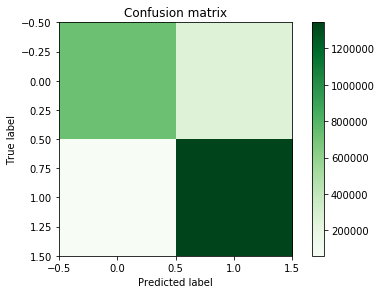

In [109]:
from sklearn.metrics import classification_report
print("Confusion Matrix:")
print(result)
result1 = classification_report(ytest, y_pred_XB)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(ytest,y_pred_XB)
print("Accuracy:",result2)

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ytest
y_pred_XB = model.predict(Xtest)


conf = confusion_matrix(y_true, y_pred_XB)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_pred_XB, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

In [174]:
train_acc_model=model.score(Xtrain, ytrain)
test_acc_model=model.score(Xtest, ytest)
print("Training Data Accuracy: %0.4f" %(train_acc_model))
print("Test Data Accuracy:     %0.4f" %(test_acc_model))

Training Data Accuracy: 0.8664
Test Data Accuracy:     0.8667


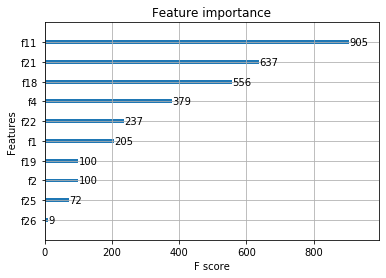

In [110]:
from xgboost import plot_importance
plot_importance(model)

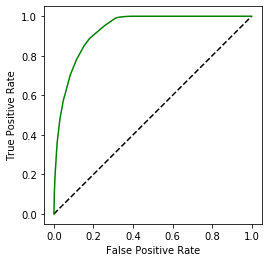

In [111]:
y_score = model.predict_proba(Xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting .
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')

# XGBoost model without parameter tuning

In [59]:
model2 = XGBClassifier()

model2.fit(Xtrain, ytrain)

[17:53:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [60]:
y_predict = model2.predict(Xtest)

Confusion Matrix:
[[ 725253  256620]
 [ 109429 1293031]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82    981873
           1       0.84      0.96      0.90   1402460

    accuracy                           0.87   2384333
   macro avg       0.89      0.85      0.86   2384333
weighted avg       0.88      0.87      0.87   2384333

Accuracy: 0.8690526868520463


Precision:              0.84
Recall:                 0.96


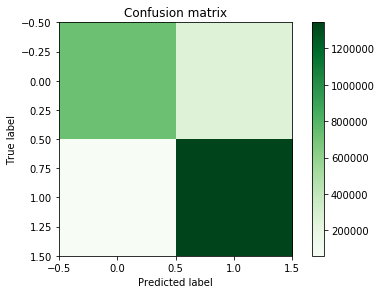

In [163]:
from sklearn.metrics import classification_report
print("Confusion Matrix:")
print(result)
result1 = classification_report(ytest, y_predict)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(ytest,y_predict)
print("Accuracy:",result2)

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ytest
y_predict = model.predict(Xtest)


conf = confusion_matrix(y_true, y_predict)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_predict, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

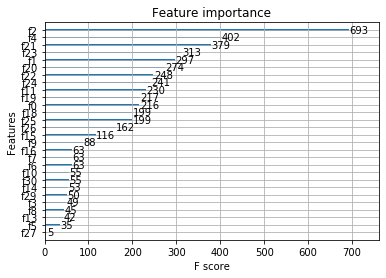

In [164]:
from xgboost import plot_importance
plot_importance(model2)

In [175]:
train_acc2=model2.score(Xtrain, ytrain)
test_acc2=model2.score(Xtest, ytest)
print("Training Data Accuracy: %0.4f" %(train_acc2))
print("Test Data Accuracy:     %0.4f" %(test_acc2))

Training Data Accuracy: 0.8712
Test Data Accuracy:     0.8691


# Random Forest Model

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
classifier = RandomForestClassifier(n_estimators = 50)

In [64]:
classifier.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [189]:
y_pred = classifier.predict(Xtest)

Confusion Matrix:
[[ 725253  256620]
 [ 109429 1293031]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80    981873
           1       0.83      0.92      0.88   1402460

    accuracy                           0.85   2384333
   macro avg       0.85      0.83      0.84   2384333
weighted avg       0.85      0.85      0.84   2384333

Accuracy: 0.8464774005979869


Precision:              0.83
Recall:                 0.92


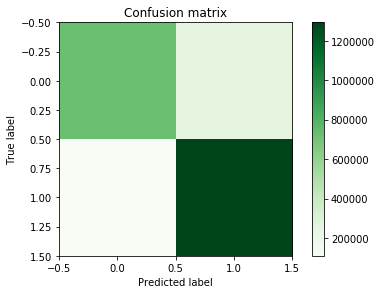

In [190]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
result = confusion_matrix(ytest, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(ytest, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(ytest,y_pred)
print("Accuracy:",result2)

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ytest
y_pred = classifier.predict(Xtest)


conf = confusion_matrix(y_true, y_pred)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_pred, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

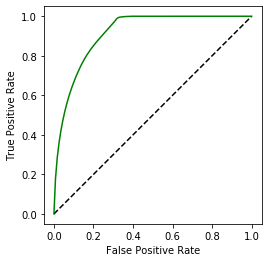

In [67]:
from sklearn.metrics import roc_curve, auc
y_score = classifier.predict_proba(Xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')

Feature ranking:
1. feature 11 (0.151079)
2. feature 12 (0.146274)
3. feature 17 (0.113039)
4. feature 2 (0.083507)
5. feature 13 (0.051821)
6. feature 14 (0.037771)
7. feature 18 (0.035467)
8. feature 15 (0.031142)
9. feature 16 (0.024815)
10. feature 1 (0.023166)
11. feature 21 (0.019922)
12. feature 19 (0.017438)
13. feature 23 (0.016347)
14. feature 25 (0.016196)
15. feature 20 (0.016001)
16. feature 0 (0.015811)
17. feature 9 (0.015388)
18. feature 26 (0.014941)
19. feature 3 (0.014902)
20. feature 10 (0.014853)
21. feature 30 (0.014833)
22. feature 29 (0.014779)
23. feature 22 (0.014735)
24. feature 24 (0.014641)
25. feature 7 (0.013303)
26. feature 8 (0.013173)
27. feature 4 (0.012455)
28. feature 28 (0.012183)
29. feature 27 (0.012154)
30. feature 5 (0.010855)
31. feature 6 (0.007007)


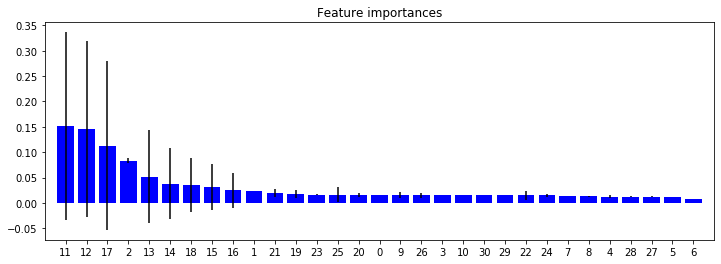

In [68]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,4))
plt.title("Feature importances")
plt.bar(range(Xtrain.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

# Constructing a Predicted Shopping cart

In [297]:
cart_prediction = pd.DataFrame({'Actual': y_true.flatten(), 'Predicted': y_pred_XB.flatten()})

In [298]:
customer_cart = df_Xtest1[['order_id', 'user_id', 'order_number','product_id']].copy().reset_index(drop=True)

In [313]:
customer_shopping_cart = pd.concat([customer_cart,cart_prediction],axis=1).reset_index(drop=True)
customer_shopping_cart = pd.merge(customer_shopping_cart,products[['product_name','product_id']],on='product_id')
customer_shopping_cart = customer_shopping_cart[['order_id','user_id','order_number','product_name','Actual','Predicted']]
customer_shopping_cart.head(10)

,order_id,user_id,order_number,product_name,Actual,Predicted
0,473747,1,3,Soda,1,1
1,2254736,1,4,Soda,1,1
2,2550362,1,10,Soda,1,1
3,61993,1344,14,Soda,0,0
4,1020683,1680,27,Soda,1,1
5,3072835,2253,22,Soda,1,1
6,2572534,2383,51,Soda,1,1
7,1529012,3033,2,Soda,0,1
8,2461787,3033,7,Soda,1,1
9,2129841,3390,7,Soda,1,1


In [312]:
customer_sample = customer_shopping_cart.user_id == 3855

selected_customer = customer_shopping_cart[customer_sample].reset_index()
selected_customer.sort_values(by=['order_id'],ascending=True, inplace=True)
selected_shopping_cart = selected_customer.head(15)
selected_shopping_cart.sort_values(by=['order_number'],ascending=True)
selected_shopping_cart

,index,order_id,user_id,order_number,product_name,Actual,Predicted
27,1615766,226047,3855,2,Protein & Greens Vanilla Flavor Drink Mix,0,0
2,832,226047,3855,2,Soda,0,1
12,241034,226047,3855,2,Cauliflower Florets,1,1
22,621606,445520,3855,16,Fresh Asparagus,0,0
26,1562562,445520,3855,16,Crumbled Bacon,0,0
10,236711,445520,3855,16,Raspberries,1,1
21,549163,682171,3855,6,Wheat Thins Original,0,0
18,411805,682171,3855,6,Fat Free Skim Milk,1,1
11,237370,682171,3855,6,Raspberries,1,1
0,12,682171,3855,6,Soda,1,1


In [314]:
customer_sample = customer_shopping_cart.user_id == 2253

selected_customer = customer_shopping_cart[customer_sample].reset_index()
selected_customer.sort_values(by=['order_id'],ascending=True, inplace=True)
selected_shopping_cart = selected_customer.head(15)
selected_shopping_cart.sort_values(by=['order_number'],ascending=True)
selected_shopping_cart

,index,order_id,user_id,order_number,product_name,Actual,Predicted
33,165767,484011,2253,18,Original Popcorn,1,1
19,111614,484011,2253,18,Apples,1,1
36,166360,484011,2253,18,Fruit Snacks,1,1
14,108620,484011,2253,18,Zero Calorie Cola,1,1
3,1889,535419,2253,19,Soda,1,1
30,165655,535419,2253,19,Original Popcorn,1,1
20,111825,535419,2253,19,Apples,1,1
16,108793,535419,2253,19,Zero Calorie Cola,1,1
12,90345,535419,2253,19,Sparkling Mineral Water,0,1
39,166592,1271085,2253,25,Vanilla Milk Chocolate Almond Ice Cream Bars M...,0,1
